In [108]:
import numpy as np
import os
import re
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

In [109]:
#dir_files = '../weights_CL/cifar100/corrupt_label/with_inst_params_lr_0.2_40frac_corrupt_labels'
#dir_files = '../weights_CL/cifar100/corrupt_label/with_pretrained_checkpoint/with_inst_params_lr_0.2_40frac_corrupt_labels/'
dir_files = '../weights_CL/cifar100/corrupt_label/with_pretrained_checkpoint/ResNet18_with_inst_params_lr_1.0_40frac/'

In [110]:
all_files = os.listdir(dir_files)

In [111]:
# Filter files that end with '.tar' and start with 'epoch_'
epoch_files = [file for file in all_files if file.endswith('.tar') and file.startswith('epoch_')]

In [112]:
# Function to extract the numerical part from the file name
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return int(match.group()) if match else 0

In [113]:
# Sort the files based on the numerical part
epoch_files.sort(key=extract_number)
epochs = [extract_number(x) for x in epoch_files]

In [114]:
print(epoch_files)

['epoch_0.pth.tar', 'epoch_2.pth.tar', 'epoch_4.pth.tar', 'epoch_6.pth.tar', 'epoch_8.pth.tar', 'epoch_10.pth.tar', 'epoch_12.pth.tar', 'epoch_14.pth.tar', 'epoch_16.pth.tar', 'epoch_18.pth.tar']


## Calculate the accuracy of detection of noisy-samples over the course of epochs

In [115]:
num_elements = 50000
frac_corrupt = 0.40
num_corrupt = int(num_elements * frac_corrupt)
inst_params_over_epochs = np.zeros((len(epochs), num_elements))
detect_corrupt_acc = []
for idx, file in tqdm(enumerate(epoch_files), total=len(epoch_files)):
    file_path = os.path.join(dir_files, file)
    inst_params = np.exp(torch.load(file_path)['inst_parameters'])
    idx_high_temperature = np.argsort(inst_params)[::-1]
    detect_corrupt_acc.append((idx_high_temperature[:num_corrupt] <= num_corrupt).mean())
    inst_params_over_epochs[idx, :] = inst_params

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.04it/s]


In [116]:
# Read gt and train labels from checkpoint
data = torch.load(file_path)
gt_labels = np.array(data['labels_dict']['gt_labels'])
train_labels = np.array(data['labels_dict']['train_labels'])

corrupt_gt = gt_labels != train_labels
assert corrupt_gt.mean() == frac_corrupt, 'Corrupt fraction mismatch'

In [117]:
# Find accuracy for detecting corrupt samples
acc_corrupt = []
acc_clean = []

for idx in range(len(epoch_files)):
    inst_params = inst_params_over_epochs[idx, :]

    sorted_idx_descending = np.argsort(inst_params)[::-1]
    corrupt_idx_predicted = sorted_idx_descending[:num_corrupt]
    clean_idx_predicted = sorted_idx_descending[num_corrupt:]

    acc_corrupt.append((corrupt_idx_predicted < num_corrupt).mean())
    acc_clean.append((clean_idx_predicted >= num_corrupt).mean())


Text(0, 0.5, 'Corrupt label detection accuracy')

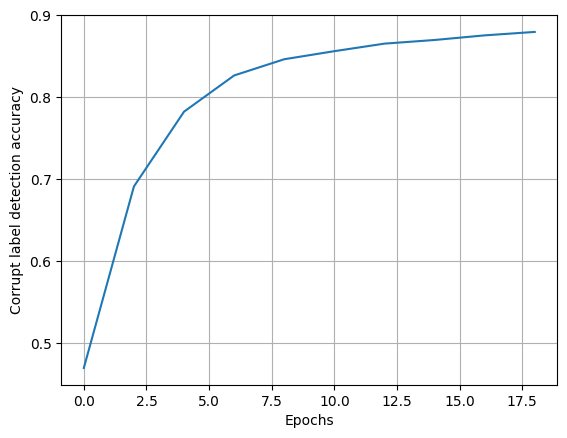

In [118]:
plt.plot(epochs, acc_corrupt)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Corrupt label detection accuracy')

## Calculate overall accuracy of noisy-outlier detection

In [119]:
# Generate prediction
corrupt_predict = np.zeros((num_elements))
corrupt_predict[sorted_idx_descending[:num_corrupt]] = 1
corrupt_predict = np.bool_(corrupt_predict)

In [120]:
overall_accuracy = 100*(corrupt_predict == corrupt_gt).mean()

In [121]:
print(f'Overall accuracy for classification of outliers: {overall_accuracy:0.2f}')

Overall accuracy for classification of outliers: 90.38


## Plot the mean and standard-deviation in temperature over epochs

In [122]:
mean_clean, mean_corrupt = [], []
std_clean, std_corrupt = [], []
for idx in range(len(epoch_files)):
    inst_params = inst_params_over_epochs[idx, :]
    inst_params_corrupt = inst_params[:num_corrupt]
    inst_params_clean = inst_params[num_corrupt:]
    mean_clean.append(inst_params_clean.mean())
    mean_corrupt.append(inst_params_corrupt.mean())

    std_clean.append(inst_params_clean.std())
    std_corrupt.append(inst_params_corrupt.std())

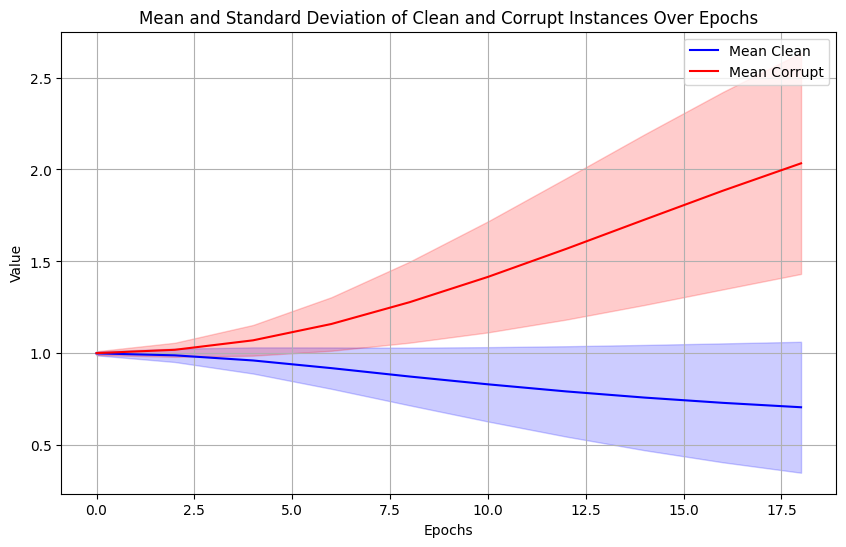

In [123]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot mean and mean±std for clean instances
plt.plot(epochs, mean_clean, label='Mean Clean', color='blue')
plt.fill_between(epochs, 
                 [m - s for m, s in zip(mean_clean, std_clean)], 
                 [m + s for m, s in zip(mean_clean, std_clean)], 
                 color='blue', alpha=0.2)

# Plot mean and mean±std for corrupt instances
plt.plot(epochs, mean_corrupt, label='Mean Corrupt', color='red')
plt.fill_between(epochs, 
                 [m - s for m, s in zip(mean_corrupt, std_corrupt)], 
                 [m + s for m, s in zip(mean_corrupt, std_corrupt)], 
                 color='red', alpha=0.2)

# Adding titles and labels
plt.title('Mean and Standard Deviation of Clean and Corrupt Instances Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.grid()
plt.legend()
